In [1]:
import os
import numpy as np
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [2]:
# Descargar el dataset Fruits 360
!mkdir /root/.kaggle/
!touch ~/.kaggle/kaggle.json

api_token = {"username":"morenobrioneswilson","key":"dc02bbb247382e3a83e40a8cbb0abc90"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 963M/964M [00:44<00:00, 23.6MB/s]
100% 964M/964M [00:44<00:00, 22.8MB/s]


In [4]:
# Descomprimir
!unzip fruits.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r0_96.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r0_98.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_0.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_10.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_100.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_102.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_104.jpg  
  inflating: fruits-360_dataset_original-size/fruits-360-original-size/Training/apple_red_yellow_1/r1_106.jpg  
  inflating: fruits-360_dataset_original-s

In [5]:
# Instalar dependencias
!pip install tensorflow opencv-python

In [6]:
# Configuraciones iniciales
image_size = (150, 150)
batch_size = 32

In [7]:
# Definir rutas del dataset
dataset_path = '/content/fruits-360_dataset_100x100/fruits-360/'
train_dir = os.path.join(dataset_path, 'Training')
test_dir = os.path.join(dataset_path, 'Test')

In [8]:
# Generadores de datos con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
)

Found 70491 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [ ]:
# Nombre de Clases
class_names = sorted(train_generator.class_indices.keys())
print("Nombre de Clases:", class_names)

# Total Clases
num_classes = len(train_generator.class_indices)
print("Numero de Clases:", num_classes)

Nombre de Clases: ['Apple 6', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple hit 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana Lady Finger 1', 'Banana Red 1', 'Beetroot 1', 'Blueberry 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1', 'Cherry Wax Black 1', 'Cherry Wax Red 1', 'Cherry Wax Yellow 1', 'Chestnut 1', 'Clementine 1', 'Cocos 1', 'Corn 1', 'Corn Husk 1', 'Cucumber 1', 'Cucumber 3', 'Cucumber Ripe 1', 'Cucumber Ripe 2', 'Dates 1', 'Eggplant 1', 'Eggplant long 1', 'Fig 1', 'Ginger Root 1', 'Granadilla 1', 'Grape Blue 1', 'Grape Pink 1', 'Grape White 1', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink 1', 'Grapefruit 

In [ ]:
# Cargar modelo base preentrenado
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Congelar capas base
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Crear el modelo personalizado
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

In [ ]:
# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [ ]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
]

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=callbacks,
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2203/2203 ━━━━━━━━━━━━━━━━━━━━ 539s 239ms/step - accuracy: 0.1668 - loss: 3.9673 - val_accuracy: 0.7276 - val_loss: 1.5656 - learning_rate: 1.0000e-04
Epoch 2/5
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 521s 236ms/step - accuracy: 0.5352 - loss: 1.8365 - val_accuracy: 0.8417 - val_loss: 0.8452 - learning_rate: 1.0000e-04
Epoch 3/5
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 519s 235ms/step - accuracy: 0.6820 - loss: 1.1915 - val_accuracy: 0.8738 - val_loss: 0.5840 - learning_rate: 1.0000e-04
Epoch 4/5
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 593s 249ms/step - accuracy: 0.7619 - loss: 0.8636 - val_accuracy: 0.8983 - val_loss: 0.4520 - learning_rate: 1.0000e-04
Epoch 5/5
2203/2203 ━━━━━━━━━━━━━━━━━━━━ 513s 232ms/step - accuracy: 0.8087 - loss: 0.6808 - val_accuracy: 0.9073 - val_loss: 0.3898 - learning_rate: 1.0000e-04


In [ ]:
# Evaluar el modelo
loss, accuracy = model.evaluate(validation_generator)
print(f"\nPérdida: {loss:.2f}, Precisión: {accuracy:.2f}")

739/739 ━━━━━━━━━━━━━━━━━━━━ 50s 68ms/step - accuracy: 0.9051 - loss: 0.3905

Pérdida: 0.39, Precisión: 0.91


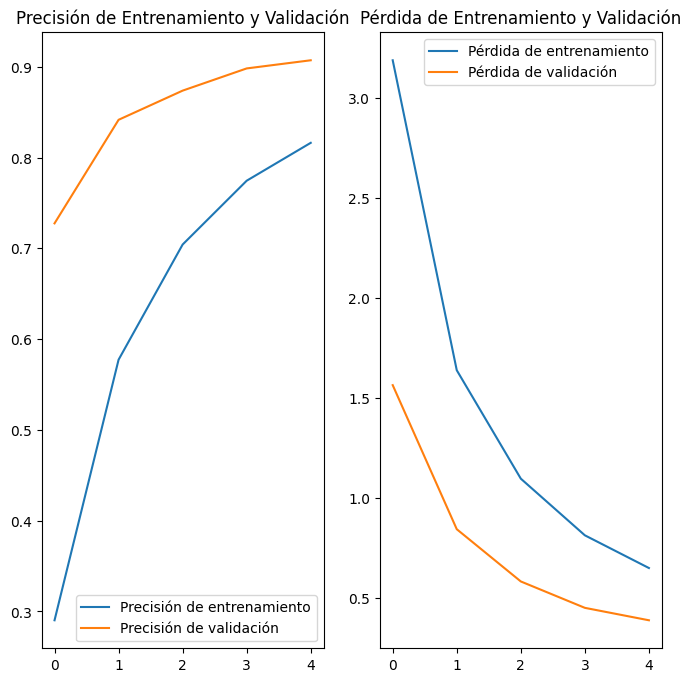

In [ ]:
# Mostrar gráficos de entrenamiento
def plot_training_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Precisión de entrenamiento")
    plt.plot(epochs_range, val_acc, label="Precisión de validación")
    plt.legend(loc="lower right")
    plt.title("Precisión de Entrenamiento y Validación")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Pérdida de entrenamiento")
    plt.plot(epochs_range, val_loss, label="Pérdida de validación")
    plt.legend(loc="upper right")
    plt.title("Pérdida de Entrenamiento y Validación")
    plt.show()

plot_training_history(history)


In [ ]:
# Función para predecir
def predict_image(image_path, model, class_indices):
    image = load_img(image_path, target_size=image_size)
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    prediction = model.predict(image_array)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicción: Quince 1
Confianza: 0.53


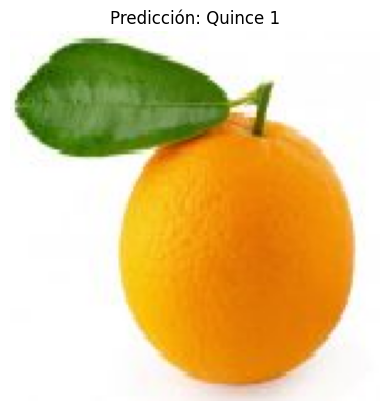

In [ ]:
#Subir la imagen
image_path = '/content/Naranja.jpg'

img = load_img(image_path, target_size=(150, 150))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

preds = model.predict(img_array)
class_indices = train_generator.class_indices
indices = {v: k for k, v in class_indices.items()}
predicted_class = indices[np.argmax(preds, axis=1)[0]]


print(f'Predicción: {predicted_class}')
print(f'Confianza: {np.max(preds):.2f}')

plt.figure()
plt.imshow(img)
plt.title(f'Predicción: {predicted_class}')
plt.axis('off')
plt.show()

In [9]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.7/901.7 kB 45.2 MB/s eta 0:00:00


In [10]:
pip install pyyaml

In [11]:
import yaml

In [27]:
import cv2

In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [13]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [14]:
# Ruta al dataset de Fruits 360 descargado desde Kaggle
data_dir = "/content/fruits-360_dataset_100x100/fruits-360"
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Test")

In [15]:
# Crear carpetas para datos YOLO
output_dir = "yolo_fruits"
for split in ["train", "val"]:
    os.makedirs(os.path.join(output_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, "labels"), exist_ok=True)

In [16]:
# Función para crear anotaciones YOLO
def create_yolo_annotations(image_path, class_id, label_path):
    with open(label_path, "w") as f:
        f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

In [17]:
# Obtener todas las imágenes y etiquetas
images = []
labels = []
classes = sorted(os.listdir(train_dir))
class_map = {cls: idx for idx, cls in enumerate(classes)}

In [18]:
# Procesar imágenes y etiquetas para entrenamiento
for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    if os.path.isdir(cls_dir):
        for img in os.listdir(cls_dir):
            if img.endswith(".jpg"):
                images.append(os.path.join(cls_dir, img))
                labels.append(class_map[cls])

In [19]:
# Dividir en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [20]:
# Mover imágenes y crear anotaciones para YOLO
def move(image_paths, label_ids, split):
    for img_path, label_id in zip(image_paths, label_ids):
        # Mover imágenes
        dest_img_path = os.path.join(output_dir, split, "images", os.path.basename(img_path))
        shutil.copy(img_path, dest_img_path)

        # Crear archivo de anotaciones
        dest_label_path = os.path.join(output_dir, split, "labels", os.path.basename(img_path).replace(".jpg", ".txt"))
        create_yolo_annotations(img_path, label_id, dest_label_path)

move(x_train, y_train, "train")
move(x_val, y_val, "val")

print("Datos organizados para YOLO.")

Datos organizados para YOLO.


In [21]:
# Configuración del entrenamiento
data_config = {
    "train": "/content/yolo_fruits/train",
    "val": "/content/yolo_fruits/val",
    "nc": 141,
    "names": ['Apple 6', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple hit 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana Lady Finger 1', 'Banana Red 1', 'Beetroot 1', 'Blueberry 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1', 'Cherry Wax Black 1', 'Cherry Wax Red 1', 'Cherry Wax Yellow 1', 'Chestnut 1', 'Clementine 1', 'Cocos 1', 'Corn 1', 'Corn Husk 1', 'Cucumber 1', 'Cucumber 3', 'Cucumber Ripe 1', 'Cucumber Ripe 2', 'Dates 1', 'Eggplant 1', 'Eggplant long 1', 'Fig 1', 'Ginger Root 1', 'Granadilla 1', 'Grape Blue 1', 'Grape Pink 1', 'Grape White 1', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink 1', 'Grapefruit White 1', 'Guava 1', 'Hazelnut 1', 'Huckleberry 1', 'Kaki 1', 'Kiwi 1', 'Kohlrabi 1', 'Kumquats 1', 'Lemon 1', 'Lemon Meyer 1', 'Limes 1', 'Lychee 1', 'Mandarine 1', 'Mango 1', 'Mango Red 1', 'Mangostan 1', 'Maracuja 1', 'Melon Piel de Sapo 1', 'Mulberry 1', 'Nectarine 1', 'Nectarine Flat 1', 'Nut Forest 1', 'Nut Pecan 1', 'Onion Red 1', 'Onion Red Peeled 1', 'Onion White 1', 'Orange 1', 'Papaya 1', 'Passion Fruit 1', 'Peach 1', 'Peach 2', 'Peach Flat 1', 'Pear 1', 'Pear 2', 'Pear 3', 'Pear Abate 1', 'Pear Forelle 1', 'Pear Kaiser 1', 'Pear Monster 1', 'Pear Red 1', 'Pear Stone 1', 'Pear Williams 1', 'Pepino 1', 'Pepper Green 1', 'Pepper Orange 1', 'Pepper Red 1', 'Pepper Yellow 1', 'Physalis 1', 'Physalis with Husk 1', 'Pineapple 1', 'Pineapple Mini 1', 'Pitahaya Red 1', 'Plum 1', 'Plum 2', 'Plum 3', 'Pomegranate 1', 'Pomelo Sweetie 1', 'Potato Red 1', 'Potato Red Washed 1', 'Potato Sweet 1', 'Potato White 1', 'Quince 1', 'Rambutan 1', 'Raspberry 1', 'Redcurrant 1', 'Salak 1', 'Strawberry 1', 'Strawberry Wedge 1', 'Tamarillo 1', 'Tangelo 1', 'Tomato 1', 'Tomato 2', 'Tomato 3', 'Tomato 4', 'Tomato Cherry Red 1', 'Tomato Heart 1', 'Tomato Maroon 1', 'Tomato Yellow 1', 'Tomato not Ripened 1', 'Walnut 1', 'Watermelon 1', 'Zucchini 1', 'Zucchini dark 1'],
}


In [22]:
#data_yaml_path = os.path.join(output_dir, "data.yaml")
data_yaml_path = "/content/yolo_fruits/data.yaml"
with open(data_yaml_path, "w") as f:
    yaml.dump(data_config, f, default_flow_style=False)

In [23]:
# Entrenar el modelo YOLOv8
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 321MB/s]


In [24]:
model.train(data=data_yaml_path, epochs=50, imgsz=100, batch=16, device="0")

Ultralytics 8.3.52 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/yolo_fruits/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=100, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 755k/755k [00:00<00:00, 103MB/s]


Overriding model.yaml nc=80 with nc=141

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralyti

100%|██████████| 5.35M/5.35M [00:00<00:00, 325MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[100] must be multiple of max stride 32, updating to [128]


train: Scanning /content/yolo_fruits/train/labels... 2049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2049/2049 [00:01<00:00, 1461.87it/s]

train: New cache created: /content/yolo_fruits/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolo_fruits/val/labels... 1410 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1410/1410 [00:00<00:00, 1626.63it/s]

val: New cache created: /content/yolo_fruits/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=6.9e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      0.26G      1.111      5.425      1.359          4        128: 100%|██████████| 129/129 [00:21<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.73it/s]

                   all       1410       1410    0.00518    0.00553    0.00317    0.00306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.224G     0.8765      5.084      1.211          4        128: 100%|██████████| 129/129 [00:15<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  7.07it/s]

                   all       1410       1410      0.229    0.00563    0.00792    0.00788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.224G     0.7248      4.609      1.129          4        128: 100%|██████████| 129/129 [00:14<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.73it/s]


                   all       1410       1410      0.237     0.0131     0.0146     0.0146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.224G     0.6404      4.239      1.092          3        128: 100%|██████████| 129/129 [00:15<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.61it/s]

                   all       1410       1410      0.265     0.0133     0.0162     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.224G     0.6071      3.947      1.077          4        128: 100%|██████████| 129/129 [00:16<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.68it/s]

                   all       1410       1410      0.201     0.0139      0.019      0.019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.224G     0.5888      3.728      1.074          2        128: 100%|██████████| 129/129 [00:14<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.59it/s]


                   all       1410       1410      0.399     0.0166     0.0306     0.0306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.224G     0.5552      3.517      1.053          1        128: 100%|██████████| 129/129 [00:14<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  8.24it/s]


                   all       1410       1410      0.423     0.0466     0.0402     0.0402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.224G     0.5326      3.266      1.049          4        128: 100%|██████████| 129/129 [00:15<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.25it/s]


                   all       1410       1410      0.578     0.0325     0.0475     0.0475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.224G     0.5297      3.063      1.055          2        128: 100%|██████████| 129/129 [00:13<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.82it/s]


                   all       1410       1410      0.634     0.0333     0.0499     0.0498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.226G     0.5048      2.884      1.038          4        128: 100%|██████████| 129/129 [00:17<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.91it/s]


                   all       1410       1410       0.65     0.0469     0.0553     0.0553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.224G     0.4953       2.74      1.039          3        128: 100%|██████████| 129/129 [00:14<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  5.97it/s]


                   all       1410       1410      0.716     0.0469     0.0594      0.058

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.226G     0.4796      2.596      1.034          4        128: 100%|██████████| 129/129 [00:14<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.98it/s]


                   all       1410       1410      0.767     0.0514     0.0671     0.0658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.226G     0.4738      2.458      1.037          2        128: 100%|██████████| 129/129 [00:14<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.77it/s]


                   all       1410       1410      0.803     0.0574     0.0711     0.0695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.226G     0.4766      2.393      1.038          2        128: 100%|██████████| 129/129 [00:14<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.15it/s]


                   all       1410       1410      0.765     0.0738     0.0817     0.0797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.226G     0.4661      2.287      1.031          4        128: 100%|██████████| 129/129 [00:16<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.80it/s]


                   all       1410       1410      0.746     0.0832     0.0862     0.0846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.226G      0.449      2.179      1.025          4        128: 100%|██████████| 129/129 [00:14<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.12it/s]


                   all       1410       1410      0.756     0.0924     0.0977      0.095

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.226G     0.4517      2.145       1.03          2        128: 100%|██████████| 129/129 [00:14<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  8.00it/s]


                   all       1410       1410      0.728     0.0931     0.0979     0.0948

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.226G     0.4426      2.062      1.027          2        128: 100%|██████████| 129/129 [00:14<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  7.19it/s]


                   all       1410       1410      0.755     0.0905       0.11      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.226G     0.4275      1.964      1.023          2        128: 100%|██████████| 129/129 [00:14<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.25it/s]


                   all       1410       1410      0.735      0.124      0.122      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.226G     0.4369      1.915      1.029          3        128: 100%|██████████| 129/129 [00:17<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.87it/s]


                   all       1410       1410      0.756      0.121      0.128      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.226G     0.4258      1.843      1.024          4        128: 100%|██████████| 129/129 [00:14<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.10it/s]


                   all       1410       1410      0.749      0.151      0.137      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.229G     0.4313      1.828      1.029          2        128: 100%|██████████| 129/129 [00:14<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.97it/s]


                   all       1410       1410      0.738      0.152      0.137      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.226G     0.4161      1.821      1.021          2        128: 100%|██████████| 129/129 [00:14<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.90it/s]


                   all       1410       1410       0.76      0.149      0.141      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.226G      0.415      1.766      1.013          4        128: 100%|██████████| 129/129 [00:14<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.05it/s]


                   all       1410       1410       0.72      0.163      0.141      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.229G     0.4011       1.71      1.013          4        128: 100%|██████████| 129/129 [00:17<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.69it/s]


                   all       1410       1410      0.702      0.178      0.149      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.229G      0.406      1.733      1.017          4        128: 100%|██████████| 129/129 [00:14<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.83it/s]


                   all       1410       1410      0.726      0.167      0.162       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.229G     0.4023      1.699      1.013          4        128: 100%|██████████| 129/129 [00:13<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.76it/s]


                   all       1410       1410      0.707      0.163      0.175      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.226G     0.3957      1.664      1.006          4        128: 100%|██████████| 129/129 [00:14<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.85it/s]


                   all       1410       1410      0.659      0.183      0.173       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.229G     0.3965      1.665      1.012          3        128: 100%|██████████| 129/129 [00:14<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.22it/s]


                   all       1410       1410       0.68      0.177      0.179      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.229G     0.4026      1.643       1.02          2        128: 100%|██████████| 129/129 [00:16<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  7.31it/s]


                   all       1410       1410      0.665      0.206      0.187      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.226G     0.3892      1.559      1.008          4        128: 100%|██████████| 129/129 [00:14<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.74it/s]


                   all       1410       1410       0.67      0.183      0.185      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.229G     0.3967      1.656      1.011          3        128: 100%|██████████| 129/129 [00:14<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.68it/s]


                   all       1410       1410      0.653      0.209      0.189      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.229G     0.3857      1.583      1.007          4        128: 100%|██████████| 129/129 [00:14<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.87it/s]


                   all       1410       1410      0.658      0.207      0.188      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.229G     0.3823      1.542      1.002          4        128: 100%|██████████| 129/129 [00:14<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.06it/s]


                   all       1410       1410      0.635      0.217      0.198      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.226G     0.3865      1.575      1.003          4        128: 100%|██████████| 129/129 [00:15<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.33it/s]


                   all       1410       1410      0.649      0.208      0.201      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.229G       0.39      1.563       1.01          1        128: 100%|██████████| 129/129 [00:14<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.11it/s]


                   all       1410       1410      0.661      0.222      0.207      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.229G     0.3677      1.514          1          2        128: 100%|██████████| 129/129 [00:14<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.82it/s]


                   all       1410       1410       0.63      0.221      0.211      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.229G     0.3749      1.506     0.9984          4        128: 100%|██████████| 129/129 [00:15<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.80it/s]


                   all       1410       1410       0.63      0.229      0.219      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.226G      0.374      1.492      1.004          4        128: 100%|██████████| 129/129 [00:14<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.46it/s]


                   all       1410       1410      0.641       0.21       0.23      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.229G     0.3742      1.533      1.008          2        128: 100%|██████████| 129/129 [00:15<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.04it/s]


                   all       1410       1410      0.601      0.234      0.227      0.224
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.229G      0.236      1.606      1.005          1        128: 100%|██████████| 129/129 [00:14<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  5.99it/s]


                   all       1410       1410       0.62      0.296      0.259      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.229G     0.1776      1.405     0.9656          1        128: 100%|██████████| 129/129 [00:14<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.72it/s]


                   all       1410       1410      0.666      0.274      0.272       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.229G     0.1557      1.358     0.9649          1        128: 100%|██████████| 129/129 [00:14<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.48it/s]


                   all       1410       1410      0.605      0.296      0.284      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.229G     0.1442      1.341      0.961          1        128: 100%|██████████| 129/129 [00:13<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  6.85it/s]


                   all       1410       1410      0.672      0.282      0.297      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.229G     0.1411      1.292     0.9493          1        128: 100%|██████████| 129/129 [00:14<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  7.43it/s]


                   all       1410       1410      0.588      0.299      0.307      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.229G     0.1362      1.297     0.9513          1        128: 100%|██████████| 129/129 [00:16<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.01it/s]


                   all       1410       1410      0.625      0.309      0.308      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.226G     0.1354       1.28     0.9448          1        128: 100%|██████████| 129/129 [00:14<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  7.30it/s]


                   all       1410       1410      0.564       0.34      0.316      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.229G     0.1325      1.244      0.946          1        128: 100%|██████████| 129/129 [00:14<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  7.24it/s]


                   all       1410       1410      0.632      0.301      0.317      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.229G     0.1352      1.242     0.9426          1        128: 100%|██████████| 129/129 [00:14<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  6.32it/s]


                   all       1410       1410        0.7      0.272      0.317      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.229G       0.13      1.255     0.9466          1        128: 100%|██████████| 129/129 [00:14<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:05<00:00,  7.79it/s]


                   all       1410       1410      0.651      0.292      0.311       0.31

50 epochs completed in 0.314 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.9MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.9MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.52 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,353,147 parameters, 0 gradients, 9.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:09<00:00,  4.59it/s]


                   all       1410       1410      0.631        0.3      0.318      0.315
               Apple 6         67         67      0.771          1      0.995       0.98
      Apple Braeburn 1          4          4          1          0     0.0443     0.0443
  Apple Crimson Snow 1          8          8          1          0     0.0354     0.0354
        Apple Golden 1          1          1          1          0    0.00921    0.00921
        Apple Golden 2          3          3          0          0     0.0518     0.0518
        Apple Golden 3          2          2          1          0      0.028      0.028
  Apple Granny Smith 1          9          9          1          0      0.114      0.114
     Apple Pink Lady 1          4          4          1          0     0.0453     0.0453
           Apple Red 1          5          5          1          0     0.0106     0.0106
           Apple Red 2          3          3          1          0     0.0809     0.0809
           Apple Red 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f99504876d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence

In [25]:
# Evaluar el modelo
results = model.val()
print(results)

Ultralytics 8.3.52 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,353,147 parameters, 0 gradients, 9.7 GFLOPs


val: Scanning /content/yolo_fruits/val/labels.cache... 1410 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1410/1410 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 89/89 [00:06<00:00, 13.74it/s]


                   all       1410       1410      0.632      0.301      0.317      0.315
               Apple 6         67         67      0.771          1      0.995       0.98
      Apple Braeburn 1          4          4          1          0     0.0442     0.0442
  Apple Crimson Snow 1          8          8          1          0     0.0355     0.0355
        Apple Golden 1          1          1          1          0    0.00905    0.00905
        Apple Golden 2          3          3          0          0     0.0506     0.0506
        Apple Golden 3          2          2          1          0     0.0283     0.0283
  Apple Granny Smith 1          9          9          1          0      0.114      0.114
     Apple Pink Lady 1          4          4          1          0     0.0466     0.0466
           Apple Red 1          5          5          1          0     0.0106     0.0106
           Apple Red 2          3          3          1          0     0.0749     0.0749
           Apple Red 

In [28]:
# Cargar la imagen
image_path = '/content/Platano.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.0
input_image = np.expand_dims(input_image, axis=0)

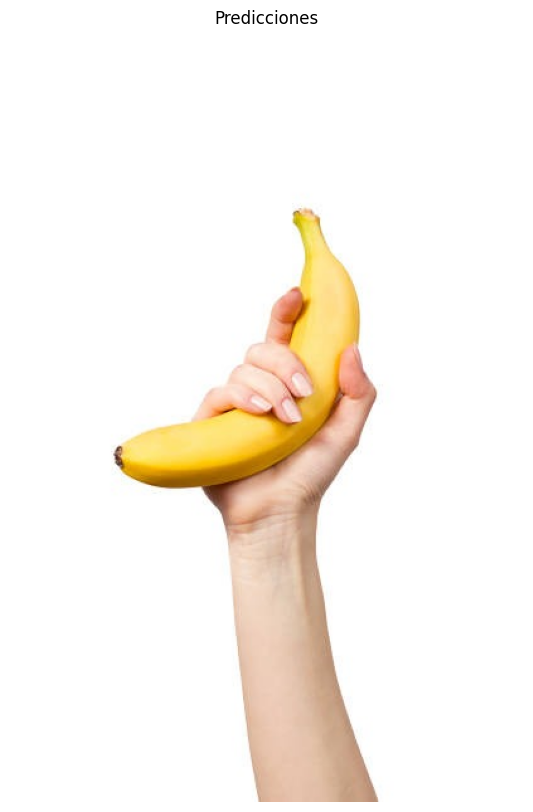

In [29]:
# Mostrar resultados
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.title("Predicciones")
plt.axis("off")
plt.show()

In [37]:
# Predecir con el modelo YOLO
predictions = model.predict(source=image_path, save=True, conf=0.25)  # Usa el modelo YOLO que has entrenado


image 1/1 /content/Platano.jpg: 128x96 (no detections), 29.3ms
Speed: 0.8ms preprocess, 29.3ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 96)
Results saved to runs/detect/train3
